In [3]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain-openai langchain-community

In [4]:
import getpass
import os
from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
        
_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")


### How to get https://app.tavily.com/sign-in? 
1. go to https://app.tavily.com/sign-in and get the API key
2. setup into .zshrc or .bashrc and source it. 
3. re-run the code. 

### Step 1: Create Tool

In [5]:
from langgraph.graph import StateGraph, END

import operator
from langchain_core.messages import AnyMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)



<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


### Step 2: Create a squad lead

In [6]:
from typing import Annotated
from typing_extensions import TypedDict


class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

    
class SquadLead:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("call_openai", self.call_openai)    # mnemonic: node == agent == add_message function reference
        graph.set_entry_point("call_openai")
        graph.add_node("take_action", self.take_action) 
        graph.add_conditional_edges(
            "call_openai",
            self.exists_action,
            {True: "take_action", False: END}
        )
        graph.add_edge("take_action", "call_openai")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        
    def exists_action(self, state: AgentState):
        print(state["messages"])
        result = state["messages"][-1]  
        return len(result.tool_calls) > 0
    
    def call_openai(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"message": [message]}

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"calling:  {t}")
            if not t["name"] in self.tools:
                print("\n ... bad tool name ...")
                result = "bad tool name, retry"
            else:
                result = self.tools[t["name"]].invoke(t["args"])
            results.append(ToolMessage(tool_call_id=t["id"], name=t["name"], content=result))
            
        print("back to the model")
        return {"message": results}
    
    

In [7]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-4o") 
abot = SquadLead(model, [tool], system=prompt)

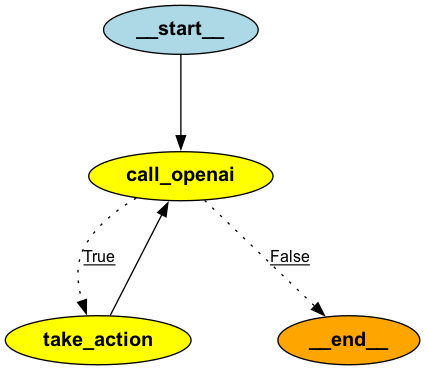

In [8]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())


In [9]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What is the capital of France?")]
result = abot.graph.invoke({"messages": messages})



InvalidUpdateError: Expected node call_openai to update at least one of ['messages'], got {'message': [AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 151, 'total_tokens': 159, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'stop', 'logprobs': None}, id='run-1dbf2cd8-c82c-49ba-858f-8a97f89f407e-0', usage_metadata={'input_tokens': 151, 'output_tokens': 8, 'total_tokens': 159, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}